In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from pygam import LogisticGAM
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_df = pd.read_csv('cleaned_data.csv')

In [3]:
data_df.head(5)

,SEQN,DIQ160,RIAGENDR,RIDAGEYR,BMXHIP,BMXWAIST,DBD895,DBD910,DBQ700,INDFMMPC,...,BPQ080,WHD020,SLQ050,SLQ120,PAD680,average_daily_sleep,physical_level,hip_to_waist_ratio,weight_change,Target
0,109266.0,1.0,2.0,29.0,126.1,117.9,7.000000e+00,5.000000e+00,3.0,3.0,...,1.0,210.0,2.0,5.397605e-79,480.0,7.642857,vigorous,1.069550,10.0,3
1,109271.0,2.0,1.0,49.0,108.2,120.4,2.000000e+00,5.397605e-79,3.0,1.0,...,1.0,222.0,1.0,3.000000e+00,60.0,10.857143,light,0.898671,42.0,0
2,109273.0,2.0,1.0,36.0,94.5,86.8,2.000000e+00,7.000000e+00,4.0,1.0,...,2.0,165.0,1.0,2.000000e+00,180.0,6.928571,moderate,1.088710,10.0,0
3,109274.0,2.0,1.0,68.0,107.8,109.6,5.397605e-79,5.397605e-79,2.0,1.0,...,1.0,219.0,2.0,5.397605e-79,300.0,9.500000,vigorous,0.983577,-11.0,1
4,109282.0,2.0,1.0,76.0,104.6,98.9,1.000000e+00,8.000000e+00,4.0,3.0,...,1.0,185.0,1.0,3.000000e+00,900.0,7.285714,sedentary,1.057634,10.0,0


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8448 entries, 0 to 8447
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEQN                 8448 non-null   float64
 1   DIQ160               8448 non-null   float64
 2   RIAGENDR             8448 non-null   float64
 3   RIDAGEYR             8448 non-null   float64
 4   BMXHIP               8448 non-null   float64
 5   BMXWAIST             8448 non-null   float64
 6   DBD895               8448 non-null   float64
 7   DBD910               8448 non-null   float64
 8   DBQ700               8448 non-null   float64
 9   INDFMMPC             8448 non-null   float64
 10  MCQ300C              8448 non-null   float64
 11  MCQ160M              8448 non-null   float64
 12  BPQ020               8448 non-null   float64
 13  BPQ080               8448 non-null   float64
 14  WHD020               8448 non-null   float64
 15  SLQ050               8448 non-null   f

## Train-Test Split and Pre-processing

In [5]:
X = data_df.drop(columns=['Target','SEQN'])
y = data_df['Target']

In [6]:
random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size ,stratify=y,random_state=random_state)

In [7]:
cat_attribs = X_train.select_dtypes('object').columns
num_attribs = X_train.select_dtypes('number').columns

transform = ColumnTransformer(transformers = [
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(sparse_output=False), cat_attribs)
],remainder='passthrough')

In [8]:
X_train_transformed = transform.fit_transform(X_train)
X_test_transformed = transform.fit_transform(X_test)

## Dummy Classifier

In [9]:
class_to_predict = y.mode()[0]

In [10]:
y_pred = [class_to_predict] * y_test.shape[0]

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set:{accuracy:.2f}")

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted):{f1_weighted:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision:{precision:.2f}")

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall:{recall:.2f}")

Accuracy on test set:0.53
F1 Score (Weighted):0.37
Precision:0.28
Recall:0.53


## Model Training and Tuning

## SVM

In [12]:
model =  SVC()

In [13]:
SVC_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10],
    
}

In [14]:
grid_clf = GridSearchCV(model, SVC_param_grid, cv=10, n_jobs=-1,scoring='f1_weighted')
grid_clf.fit(X_train_transformed,y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='f1_weighted')

In [15]:
SVC_best_param = grid_clf.best_params_

In [16]:
model = grid_clf.best_estimator_

In [17]:
scores = cross_val_score(model,X_train_transformed,y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Accuracy: 79.31% (+/- 2.08)


In [18]:
y_pred = model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set:{accuracy:.2f}")

Accuracy on test set:0.79


In [19]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted):{f1_weighted:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision:{precision:.2f}")

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall:{recall:.2f}")

F1 Score (Weighted):0.76
Precision:0.74
Recall:0.79


## Random Forests

In [20]:
model = RandomForestClassifier()

In [21]:
RF_params = {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [None,4, 6, 8, 10, 12]
}

In [22]:
grid_clf = GridSearchCV(model, RF_params, cv=10, n_jobs=-1,scoring='f1_weighted')
grid_clf.fit(X_train_transformed,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 4, 6, 8, 10, 12],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='f1_weighted')

In [23]:
RF_best_params = grid_clf.best_params_

In [24]:
model = grid_clf.best_estimator_

In [25]:
scores = cross_val_score(model,X_train_transformed,y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Accuracy: 79.28% (+/- 1.21)


In [26]:
y_pred = model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set:{accuracy:.2f}")

Accuracy on test set:0.80


In [27]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted):{f1_weighted:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision:{precision:.2f}")

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall:{recall:.2f}")

F1 Score (Weighted):0.76
Precision:0.79
Recall:0.80


## Multinomial logistic Classification

In [28]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [29]:
LR_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

In [30]:
grid_clf = GridSearchCV(model, LR_param_grid, cv=10, n_jobs=-1,scoring = 'f1_weighted')
grid_clf.fit(X_train_transformed,y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial'),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='f1_weighted')

In [31]:
LR_best_param = grid_clf.best_params_

In [32]:
model = grid_clf.best_estimator_

In [33]:
scores = cross_val_score(model,X_train_transformed,y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Accuracy: 79.52% (+/- 1.85)


In [34]:
y_pred = model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set:{accuracy:.2f}")

Accuracy on test set:0.79


In [35]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted):{f1_weighted:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision:{precision:.2f}")

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall:{recall:.2f}")

F1 Score (Weighted):0.77
Precision:0.77
Recall:0.79


## XGBoost

In [36]:
model = XGBClassifier()

In [37]:
xgbc_params = {
        "learning_rate": [0.01, 0.05, 0.1, 0.15],
        "max_depth": [3, 4, 5, 6],
        "n_estimators": [50,100,150,200,250,300]
}

In [38]:
grid_clf = GridSearchCV(model, xgbc_params, cv=10, n_jobs=-1,scoring = 'f1_weighted')
grid_clf.fit(X_train_transformed,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='f1_weighted')

In [39]:
XGB_best_param = grid_clf.best_params_

In [40]:
model = grid_clf.best_estimator_

In [41]:
scores = cross_val_score(model,X_train_transformed,y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Accuracy: 79.86% (+/- 1.88)


In [42]:
y_pred = model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set:{accuracy:.2f}")

Accuracy on test set:0.77


In [43]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted):{f1_weighted:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision:{precision:.2f}")

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall:{recall:.2f}")

F1 Score (Weighted):0.71
Precision:0.67
Recall:0.77


## ROC Curve for best model

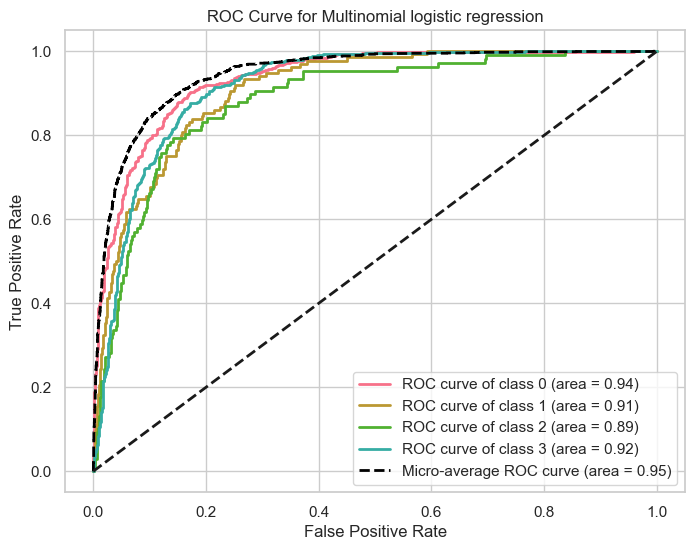

In [44]:
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

classifier_ovr = OneVsRestClassifier(LogisticRegression(**LR_best_param,multi_class='multinomial', solver='lbfgs', max_iter=1000))
classifier_ovr.fit(X_train_transformed, y_train_bin)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_train))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], classifier_ovr.predict_proba(X_test_transformed)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), classifier_ovr.predict_proba(X_test_transformed).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Set the style and color palette for the plot
sns.set(style="whitegrid")
sns.set_palette("husl")

# Plot ROC curve for each class using Seaborn and Matplotlib
plt.figure(figsize=(8, 6))
colors = cycle(sns.color_palette())  # Define colors for each class
for i, color in zip(range(len(np.unique(y_train))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='black', linestyle='--', linewidth=2)

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multinomial logistic regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()